In [0]:
!pip install keras_sequential_ascii

import numpy as np

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, CuDNNLSTM
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.core import Reshape
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics

from sklearn.utils import shuffle

import random

In [0]:
# Connecting gDrive to gColab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Dataset variables
num_train = 6000
num_test = 1500
num_val = 1500

In [0]:
# Copying data files to Colab
!cp "/content/gdrive/My Drive/PPSSP/data/Difr.txt" "sig.txt"
!cp "/content/gdrive/My Drive/PPSSP/data/MinBias.txt" "bg.txt"

In [0]:
# Reading files into list array
with open("sig.txt") as sig:
  pythia_sig = [line.split() for line in sig]

pythia_sig = np.array(pythia_sig)

with open("bg.txt") as bg:
  pythia_bg = [line.split() for line in bg]
  
pythia_bg = np.array(pythia_bg)

In [0]:
# Filling tag arrays
pythia_sig_tag = np.full((pythia_sig.shape[0], 1), 1)
pythia_bg_tag = np.full((pythia_bg.shape[0], 1), 0)

In [0]:
# Merging datasets
pythia = np.concatenate((pythia_sig, pythia_bg), axis = 0) 
pythia_tag = np.concatenate((pythia_sig_tag, pythia_bg_tag), axis = 0)

In [0]:
# Shuffling data
pythia, pythia_tag = shuffle(pythia, pythia_tag)

In [0]:
# Sorting by pT
'''
for k in range(len(pythia)):
  for i in range(0,len(pythia[k]),3): 
    min_idx = i 
    for j in range(i+3,len(pythia[k]),3): 
        if pythia[k][min_idx] > pythia[k][j]: 
            min_idx = j     
    pythia[k][i], pythia[k][min_idx] = pythia[k][min_idx], pythia[k][i] 
    pythia[k][i+1], pythia[k][min_idx+1] = pythia[k][min_idx+1], pythia[k][i+1] 
    pythia[k][i+2], pythia[k][min_idx+2] = pythia[k][min_idx+2], pythia[k][i+2]
'''

'\nfor k in range(len(pythia)):\n  for i in range(0,len(pythia[k]),3): \n    min_idx = i \n    for j in range(i+3,len(pythia[k]),3): \n        if pythia[k][min_idx] > pythia[k][j]: \n            min_idx = j     \n    pythia[k][i], pythia[k][min_idx] = pythia[k][min_idx], pythia[k][i] \n    pythia[k][i+1], pythia[k][min_idx+1] = pythia[k][min_idx+1], pythia[k][i+1] \n    pythia[k][i+2], pythia[k][min_idx+2] = pythia[k][min_idx+2], pythia[k][i+2]\n'

In [0]:
# Sorting by eta
'''
for k in range(len(pythia)):
  for i in range(1,len(pythia[k]),3): 
    min_idx = i 
    for j in range(i+3,len(pythia[k]),3): 
        if pythia[k][min_idx] > pythia[k][j]: 
            min_idx = j     
    pythia[k][i-1], pythia[k][min_idx-1] = pythia[k][min_idx-1], pythia[k][i-1] 
    pythia[k][i], pythia[k][min_idx] = pythia[k][min_idx], pythia[k][i] 
    pythia[k][i+1], pythia[k][min_idx+1] = pythia[k][min_idx+1], pythia[k][i+1]
'''

'\nfor k in range(len(pythia)):\n  for i in range(1,len(pythia[k]),3): \n    min_idx = i \n    for j in range(i+3,len(pythia[k]),3): \n        if pythia[k][min_idx] > pythia[k][j]: \n            min_idx = j     \n    pythia[k][i-1], pythia[k][min_idx-1] = pythia[k][min_idx-1], pythia[k][i-1] \n    pythia[k][i], pythia[k][min_idx] = pythia[k][min_idx], pythia[k][i] \n    pythia[k][i+1], pythia[k][min_idx+1] = pythia[k][min_idx+1], pythia[k][i+1]\n'

In [0]:
# Removing phi
'''
for k in range(len(pythia)):
  s = 0
  for i in range(2,len(pythia[k]),3):
    del pythia[k][i-s]
    s = s+1
'''

'\nfor k in range(len(pythia)):\n  s = 0\n  for i in range(2,len(pythia[k]),3):\n    del pythia[k][i-s]\n    s = s+1\n'

In [0]:
# Temporary variables for data sorting
num_fit = num_train + num_test
num_total = num_train + num_test + num_val

In [0]:
# Data sorting
xx_train_pythia = pythia[0:num_train]
xx_test_pythia = pythia[num_train:num_fit]
xx_val_pythia = pythia[num_fit:num_total]

yy_train_pythia = pythia_tag[0:num_train]
yy_test_pythia= pythia_tag[num_train:num_fit]
yy_val_pythia = pythia_tag[num_fit:num_total]

yy_train_pythia = np_utils.to_categorical(yy_train_pythia, 2)
yy_test_pythia = np_utils.to_categorical(yy_test_pythia, 2)
yy_val_pythia = np_utils.to_categorical(yy_val_pythia, 2)

In [0]:
# Model variables
batch_size = 1
epochs = 64

# Used dataset
xx_train = xx_train_pythia
xx_test = xx_test_pythia
xx_val = xx_val_pythia

yy_train = yy_train_pythia
yy_test = yy_test_pythia
yy_val = yy_val_pythia

In [0]:
# Define Model
def base_model():
  model = Sequential()
  
  # Reshape fixed-shape input (padded list/histogram) for convnet
  """
  if xx_train.shape[1] == 3*r1_N:
    model.add(Reshape((xx_train.shape[1], 1), input_shape=(xx_train.shape[1], )))  
  elif xx_train.shape[1] == r3_dim[0]:
    model.add(Reshape((xx_train.shape[1], xx_train.shape[2], 1), input_shape=(xx_train.shape[1], xx_train.shape[2], )))
  """
  
  model.add(CuDNNLSTM(35, return_sequences = False, input_shape = (None, 1)))
  model.add(Dropout(rate = 0.3))
  model.add(Dense(2, activation = 'softmax'))
  
# Train model
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [metrics.categorical_accuracy]) 
  return model

In [0]:
# Vizualizing model structure
# Model summary (ascii)
cnn_n = base_model()
cnn_n.summary()

# Model printout (ascii)
# sequential_model_to_ascii_printout(cnn_n)

# Plotting model in graphical mode
plot_model(cnn_n)   ###, to_file='model.png')  ###, show_shapes=True

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_6 (CuDNNLSTM)     (None, 35)                5320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 72        
Total params: 5,392
Trainable params: 5,392
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Custom batch generator
# Generates single event batch with fixed dimensions
def generator(X, y, size):
  while True:
    for i in range(size):
      tmp_x = np.expand_dims(X[i],1)
      tmp_x = np.reshape(tmp_x, (1, tmp_x.shape[0], 1))
      tmp_y = np.reshape(y[i], (1, y.shape[1]))
      yield tmp_x, tmp_y

In [0]:
# Custom batch generator
# Same as before but this time without tags
def generator_predict(X, size):
  while True:
    for i in range(size):
      tmp = np.expand_dims(X[i], 1)
      tmp = np.reshape(tmp, (1, tmp.shape[0], 1))
      yield tmp

In [0]:
# Patient early stopping
es = EarlyStopping(monitor = 'val_categorical_accuracy', mode = 'max', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model_lstm_var_2.h5', monitor = 'val_categorical_accuracy', mode = 'max', verbose = 1, save_best_only = True)

# Fitting model
cnn = cnn_n.fit_generator(generator(xx_train, yy_train, num_train), steps_per_epoch = (num_train//batch_size), epochs = epochs, validation_data = generator(xx_test, yy_test, num_test), validation_steps = (num_test//batch_size), shuffle = True, callbacks = [es, mc])

# Loading the saved model
saved_model = load_model('best_model_lstm_var_2.h5')


Epoch 1/64
6000/6000 [==============================] - 36s 6ms/step - loss: 0.5356 - categorical_accuracy: 0.7273 - val_loss: 0.4104 - val_categorical_accuracy: 0.8127

Epoch 00001: val_categorical_accuracy improved from -inf to 0.81267, saving model to best_model_lstm_var_2.h5
Epoch 2/64
6000/6000 [==============================] - 35s 6ms/step - loss: 0.3895 - categorical_accuracy: 0.8272 - val_loss: 0.3254 - val_categorical_accuracy: 0.8520

Epoch 00002: val_categorical_accuracy improved from 0.81267 to 0.85200, saving model to best_model_lstm_var_2.h5
Epoch 3/64
6000/6000 [==============================] - 35s 6ms/step - loss: 0.2798 - categorical_accuracy: 0.8785 - val_loss: 0.2463 - val_categorical_accuracy: 0.8940

Epoch 00003: val_categorical_accuracy improved from 0.85200 to 0.89400, saving model to best_model_lstm_var_2.h5
Epoch 4/64
6000/6000 [==============================] - 35s 6ms/step - loss: 0.2392 - categorical_accuracy: 0.9033 - val_loss: 0.2191 - val_categorical_ac

In [0]:
# Evaluating loaded model
scores_train = saved_model.evaluate_generator(generator(xx_train, yy_train, num_train), steps = (num_train//batch_size), verbose = 0)
scores_test  = saved_model.evaluate_generator(generator(xx_test,  yy_test, num_test), steps = (num_test//batch_size),  verbose = 0)
scores_val   = saved_model.evaluate_generator(generator(xx_val,   yy_val, num_val), steps = (num_val//batch_size),   verbose = 0)
print("Accuracy: Train: %.2f%%, Test: %.2f%%, Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

Accuracy: Train: 97.28%, Test: 96.87%, Val: 95.87% 


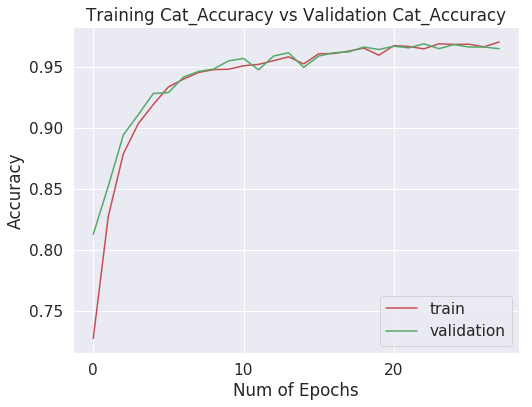

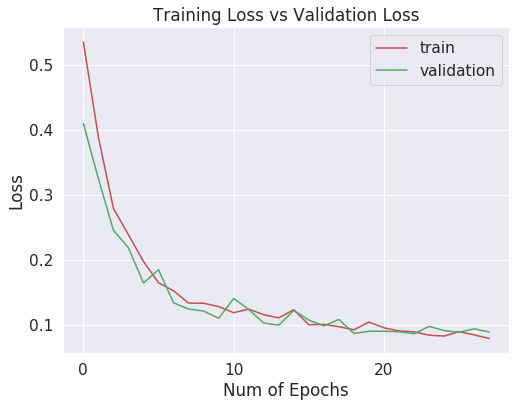

In [0]:
# Plots for training and testing process: loss and accuracy
n_epochs = len(cnn.history['loss'])

plt.figure(0)
plt.plot(cnn.history['categorical_accuracy'],'r')
plt.plot(cnn.history['val_categorical_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

[[687  40]
 [ 22 751]]


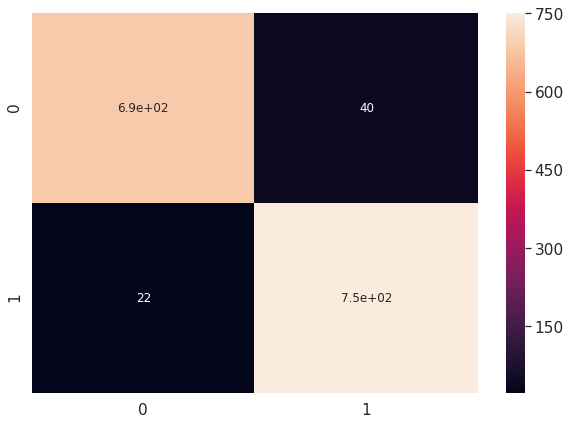

In [0]:
# Confusion matrix result
from sklearn.metrics import classification_report, confusion_matrix
YY_pred = saved_model.predict_generator(generator_predict(xx_val, num_val), steps = (num_val//batch_size), verbose=2)
yy_pred = np.argmax(YY_pred, axis=1)

yy_test2 = np.argmax(yy_test, axis=1)

# Confusion matrix
cm = confusion_matrix(np.argmax(yy_val,axis=1),yy_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize = (10,7))
sn.set(font_scale = 1.4)#for label size
sn.heatmap(df_cm, annot = True, annot_kws = {"size": 12})# font size
plt.show()